In [2]:
from keras.models import  load_model
from keras.utils import np_utils
import glob
import numpy as np
import os
import sed_eval
import dcase_util
import pickle
#%run shared_functions.ipynb

from PIL import Image

Using TensorFlow backend.


In [3]:

def getStackFeatMat(scene):
    with open(scene, "rb" ) as scenesample:
        l,fv = pickle.load(scenesample)
    return fv,l

def reduceLabels(labels):
    r,c=labels.shape 
    npOfLabels=np.zeros(c)
    for j in range(0,c):
        if np.sum(labels[:,j])>0:
            npOfLabels[j]=1
    return npOfLabels


def fileLists():
    trainlist=[]
    validationlist=[]
    testlist=[]
    evalSetupFiles='..\\..\\CASAdatasets\\DCASE18_ASCT1\\TUT-urban-acoustic-scenes-2018-development\\evaluation_setup\\*.txt'
    txtfilelist=glob.glob(evalSetupFiles)
    for txt in txtfilelist:
        if '_location' not in txt:
            continue
        if 'train' in txt:
            continue
        with open(txt,'r') as evaltxtfile:
            for line in evaltxtfile.readlines():
                line=line.strip().split('\t')[0]
                if 'train' in txt:
                    trainlist.append(line.replace('audio','logMelSpec').replace('.wav','_aggScenes.pckl').replace('/','\\'))
                elif 'test' in txt:
                    testlist.append(line.replace('audio','logMelSpec').replace('.wav','_aggScenes.pckl').replace('/','\\'))
                else:
                    validationlist.append(line.replace('audio','logMelSpec').replace('.wav','_aggScenes.pckl').replace('/','\\'))
    print('validationfiles: ', str(len(validationlist)))
    print('testfiles: ', str(len(testlist)))
    return validationlist,testlist

labelRef={'airport-barcelona':0,'shopping_mall-barcelona':1,'metro_station-barcelona':2,'street_pedestrian-barcelona':3,'public_square-barcelona':4, 
          'street_traffic-barcelona':5, 'tram-barcelona':6,'bus-barcelona':7,'metro-barcelona':8,'park-barcelona':9,
          'airport-helsinki':10,'shopping_mall-helsinki':11,'metro_station-helsinki':12,'street_pedestrian-helsinki':13,'public_square-helsinki':14, 
          'street_traffic-helsinki':15,'tram-helsinki':16,'bus-helsinki':17,'metro-helsinki':18,'park-helsinki':19,
          'airport-london':20,'shopping_mall-london':21,'metro_station-london':22,'street_pedestrian-london':23,'public_square-london':24,
          'street_traffic-london':25,'tram-london':26,'bus-london':27,'metro-london':28,'park-london':29,
          'airport-paris':30,'shopping_mall-paris':31,'metro_station-paris':32,'street_pedestrian-paris':33,'public_square-paris':34,
          'street_traffic-paris':35,'tram-paris':36,'bus-paris':37,'metro-paris':38,'park-paris':39,
          'airport-stockholm':40, 'shopping_mall-stockholm':41,'metro_station-stockholm':42,'street_pedestrian-stockholm':43,'public_square-stockholm':44,
          'street_traffic-stockholm':45,'tram-stockholm':46,'bus-stockholm':47,'metro-stockholm':48,'park-stockholm':49,
          'airport-vienna':50,'shopping_mall-vienna':51,'metro_station-vienna':52,'street_pedestrian-vienna':53,'public_square-vienna':54,
          'street_traffic-vienna':55,'tram-vienna':56,'bus-vienna':57,'metro-vienna':58,'park-vienna':59}

nb_classes=len(labelRef.keys())
def getData(flist):
    pth='..\\..\\CASAdatasets\\DCASE18_ASCT1\\TUT-urban-acoustic-scenes-2018-development\\'
    X_=np.zeros(((len(flist)),128,431))
    Y_=np.zeros(((len(flist)),nb_classes))
    for i,tfile in enumerate(flist):
        with open(pth+tfile, "rb" ) as scenesample:
            fv=pickle.load(scenesample)
        X_[i,:,:]=fv
        location='-'.join(tfile.split('\\')[1].split('-')[0:2])
        Y_[i,labelRef[location]]=1
    return X_, Y_
validationlist,testlist=fileLists()
X_v, Y_val = getData(validationlist)
X_te, Y_test = getData(testlist)
print('data obtained')
X_val=np.expand_dims(X_v,axis=3)
X_test=np.expand_dims(X_te,axis=3)

validationfiles:  2518
testfiles:  2518
data obtained


In [4]:
path='models\\best_model60_simple.hdf5'
model=load_model(path)
nb_classes=60
evaluation=model.evaluate(X_test, Y_test, verbose=0,batch_size=8)
print(model.metrics_names)
print(evaluation)

['loss', 'acc']
[2.2878271411864697, 0.37053216838760922]


60


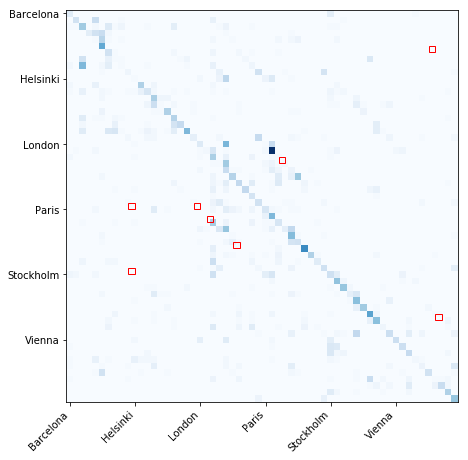

In [60]:
#evaluate performance of each model
#path='models\\best_model60.hdf5'
#model=load_model(path)
#nb_classes=60
#predictions=np.zeros((Y_test.shape))
#predictions=model.predict(X_test, verbose=0, batch_size=16) #
#USE PREDICTIONS TO CREATE CM
#print(predictions.shape)
#cmat=np.zeros((60,60))
#for i, gt in enumerate(Y_test):
#    classPred = np.where(predictions[i,:] == max(predictions[i,:]))
#    classgt=np.where(gt==max(gt))
#    cmat[classgt,classPred]=cmat[classgt,classPred]+1
#print(cmat)
cities={'Barcelona':0,'Helsinki':1,'London':2,'Paris':3,'Stockholm':4,'Vienna':5}
plot_confusion_matrix(cmat, cities,list(labelRef.keys()),output='cities_scenes_simpleV2.pdf')

In [36]:
def hv(preds):
    scene=[]
    s,r=preds.shape
    hv=np.zeros((s,r))
    for i in range(0,s):
        for j in range(0,r):
             if preds[i,j]>globalthreshold:
                hv[i,j]=1
    return hv

print(predictions.shape)
globalthreshold=0.2
test_scenes=hv(predictions)
print(test_scenes.shape)
print(sum(test_scenes))

def asc(scene,evaluate):
    correct=0  
    for idx,s in enumerate(scene):
        match=False
        if sum(s)>1:
            print('WARNING:')
            print(s)
        for j,element in enumerate(s):
            if element==Y_test[idx][j] and element==1:
                match=True
        if match:
            correct=correct+1
    
    print('*** ASC:')
    print('correct scenes: ' +str(correct)+ '\n Accuracy:')
    print(correct/len(Y_test)) 
    return correct/len(Y_test)

acc=asc(test_scenes,'test')

(2518, 6)
(2518, 6)
[ 529.  143.  333.  555.  589.  630.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  1.  1.  0.]
[ 1.  1.  0.  0.  1.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  1.  1.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 1.  0.  0.  0.  1.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  

[ 0.  0.  0.  0.  1.  1.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  0.  1.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  1.  1.]
[ 1.  0.  0.  1.  0.  0.]
[ 1.  0.  0.  0.  1.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 0.  0.  1.  1.  1.  0.]
[ 0.  0.  1.  0.  1.  0.]
[ 0.  0.  1.  0.  1.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  1.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  0.  1.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 1.  0.  0.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  0.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 0.  0.  1.  1.  0.  0.]
[ 1.  0.  1.

In [59]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.patches as patches

def plot_confusion_matrix(mat, classes, labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          output = None):
    
    print(len(labels))
    size = 3.5 + len(classes) * 0.5
    fig=plt.figure(figsize=(size, size))
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    #plt.title(title)
  #  plt.colorbar()
    tick_marks = np.arange(60, step=10)
    plt.xticks(tick_marks, classes, rotation=45, horizontalalignment='right')
    plt.yticks(tick_marks, classes)

    fmt = '.0f' 
    thresh = mat.max() / 2.
    ax = plt.gca()
    for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
       # plt.text(j, i, format(mat[i, j], fmt),
       #          horizontalalignment="center", verticalalignment="center",
       #          color="white" if mat[i, j] > thresh else "black")
        #yogi added if - are confusions matching scenes?
        if mat[i,j]>10 and i!=j:
            x=labels[i].split('-')[0]
            y=labels[j].split('-')[0]
            if x==y:
                ax.add_patch(patches.Rectangle((i, j), 1, 1, fill=False, edgecolor='red', lw=1))

    plt.tight_layout()
    #plt.ylabel('True label')
    #plt.xlabel('Predicted label')
    
    if output is not None:
        plt.savefig(output, bbox_inches='tight')
        
#strip out non-supermarket events

#scene_mat=np.random.randint(9, size=(6, 6)) #need actual class values for this!
#classes=[labelRef.keys()]
#plot_confusion_matrix(scene_mat, classes, title='', output='scenes.pdf')
